### Градиентный бустинг. AdaBoost

In [1]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [4]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def residual(y, z):
    return - (z - y)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [11]:
def get_error_plot(parametr, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    #plt.xlim(0, parametr)
    plt.plot(parametr, train_err, label='train error')
    plt.plot(parametr, test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

##### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

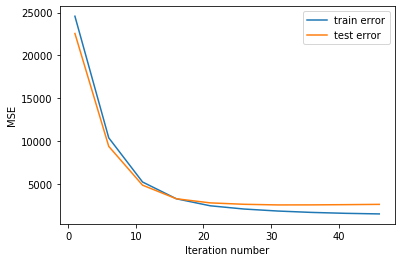

In [12]:
# Варьируем число деревьев в ансамбле
max_depth = 3
eta = 0.1
trees_n = []
train_mse = []
test_mse = []
for n_trees in range(1, 51, 5):
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    trees_n.append(n_trees)
    train_mse.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
    test_mse.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
get_error_plot(trees_n, train_mse, test_mse)

При увеличении количества деревьев уменьшается средняя квадратичная ошибка, но после ~20 деревьев уменьшение MSE на тестовой выборке практичски не происходит.

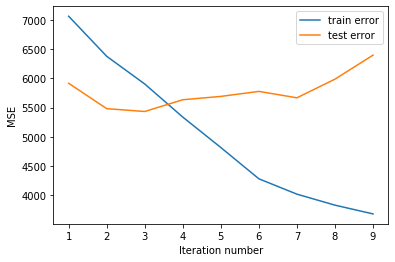

In [13]:
# Варьируем глубину деревьев в ансамбле
eta = 0.1
n_trees = 10
train_mse = []
test_mse = []
max_depths = []
for max_depth in range(1, 10):
    max_depths.append(max_depth)
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    train_mse.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
    test_mse.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
get_error_plot(max_depths, train_mse, test_mse)

При увеличении глубины дерева аглоритм быстро переобучается на тренировочной выборке.

##### 2. *Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [15]:
def gb_st__fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    """Функция обучения стохастического градиентного бустинга.
    """
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        
        # подготавливаем случайную половину датасета для стохастического обучения
        X_train_subset, X_test_subset, y_train_subset, y_test_subset = model_selection.train_test_split(X_train, y_train, 
                                                                                                        test_size=0.50)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево
            tree.fit(X_train_subset, y_train_subset)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_subset, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_subset, bias(y_train_subset, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

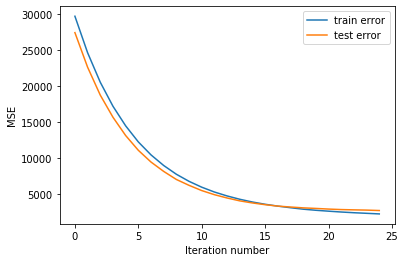

In [17]:
max_depth = 3
eta = 0.1
n_trees = 25
trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
get_error_plot(list(range(n_trees)), train_errors, test_errors)